In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from PIL import Image

#IMPORT SKLEARN
from sklearn.metrics import classification_report,confusion_matrix

In [47]:
# Define a Callback class that stops training once accuracy reaches 90.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 85.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(include_top = False, weights = "imagenet")

for layer in base_model.layers:
    layer.trainable = False
    
model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(1024, activation='relu'),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(4, activation="softmax")])

model.compile(loss ='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

9412608/9406464 [==============================] - 12s 1us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 3,573,828
Trainable params: 1,315,844
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
labels = ['oreo', 'indomie', 'ultra-milk', 'aqua']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        path = os.path.join(path, 'camera')
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [26]:
#Now we can easily fetch our validation data.
dataset = get_data('./dataset/')
np.random.shuffle(dataset)

#train = get_data('D:/Harits/Github/cloudless-ml/InceptionV3/Training/')
#val = get_data('D:/Harits/Github/cloudless-ml/InceptionV3/Validation/')

<ipython-input-25-fb70431cb08d>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [35]:
train_size = 0.6
val_size = 0.4
dataset_size = dataset.shape[0]

slice_index = int(train_size * dataset_size)

train = dataset[:slice_index]
val = dataset[slice_index:]

Text(0.5, 1.0, 'oreo')

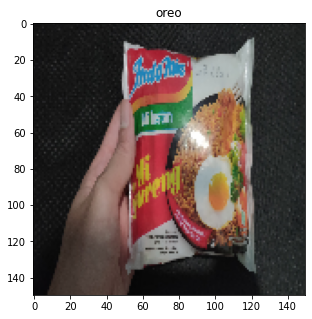

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'ultra-milk')

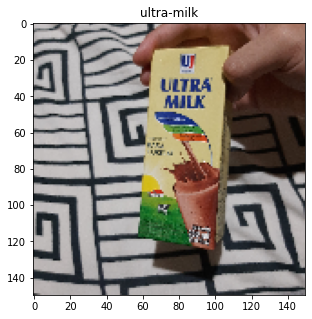

In [37]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [38]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [39]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(x_train)

In [45]:
from numpy.random import seed
seed(1337)
#from tensorflow import set_random_seed
#set_random_seed(1337)
tf.random.set_seed(1337)

In [48]:
callbacks = myCallback()
history = model.fit(x_train,
                    y_train,
                    batch_size=40,
                    epochs=10,
                    verbose = 1,
                    callbacks=[callbacks],
                    validation_data = (x_val, y_val))

Epoch 1/10
18/18 [==============================] - 18s 1s/step - loss: 0.0071 - accuracy: 0.2625 - val_loss: 4.4755e-04 - val_accuracy: 0.2313
Epoch 2/10
18/18 [==============================] - 21s 1s/step - loss: 0.0011 - accuracy: 0.2625 - val_loss: 1.7252e-04 - val_accuracy: 0.2313
Epoch 3/10
18/18 [==============================] - 20s 1s/step - loss: 1.2397e-04 - accuracy: 0.2625 - val_loss: 0.0031 - val_accuracy: 0.2313
Epoch 4/10
18/18 [==============================] - 21s 1s/step - loss: 1.8472e-05 - accuracy: 0.2625 - val_loss: 0.0050 - val_accuracy: 0.2313
Epoch 5/10
18/18 [==============================] - 22s 1s/step - loss: 5.2307e-04 - accuracy: 0.2625 - val_loss: 4.7324e-04 - val_accuracy: 0.2313
Epoch 6/10
18/18 [==============================] - 22s 1s/step - loss: 3.3746e-04 - accuracy: 0.2625 - val_loss: 0.0011 - val_accuracy: 0.2313
Epoch 7/10
18/18 [==============================] - 23s 1s/step - loss: 6.2007e-05 - accuracy: 0.2625 - val_loss: 0.0031 - val_accur

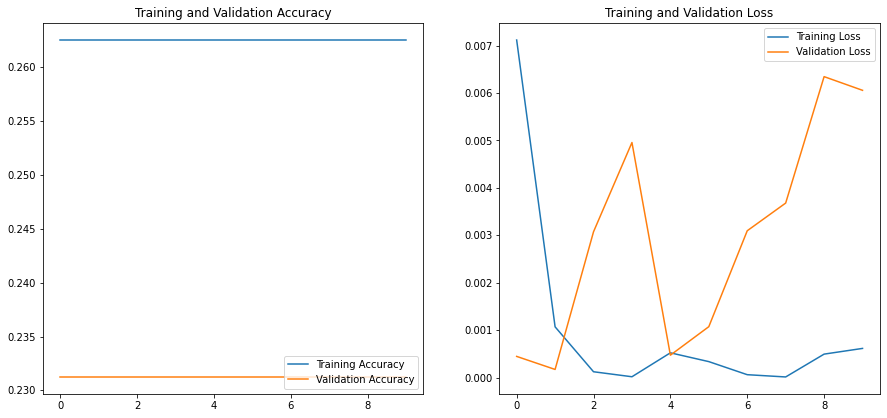

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['oreo', 'indomie', 'ultra-milk', 'aqua']))

/home/bnararya/workspace/cloudless/cl_venv/lib64/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

        oreo       1.00      1.00      1.00       111
     indomie       1.00      1.00      1.00       125
  ultra-milk       0.99      1.00      1.00       121
        aqua       1.00      0.99      1.00       123

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [53]:
#ADD SAVE PATH

model.save('D:/Harits/Github/cloudless-ml/model/mobilenetv2_model.h5')

/home/bnararya/workspace/cloudless/cl_venv/lib64/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
